# Data Assimilation using ESMDA in Reservoir Simulation

*Advanced Data Assimilation using Ensemble Smoother Multiple Data Assimilation (ESMDA) in Reservoir Simulation.*

**Dev-Notebook for DA-EM**

## TODOs
- move ESMDA to rs

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import reservoir_simulator as rs

%load_ext autoreload
%autoreload 2   
#%load_ext line_profiler
#%load_ext memory_profiler

## Model parameters

In [2]:
# Grid extension
nx = 25 #20 # 60
ny = 25 #10 # 30
nc = nx*ny

# Permeabilities
perm_mean = 3.0
perm_min = 0.5
perm_max = 5.0 

# ESMDA parameters
ne = 100    # number of ensembles
dt = np.ones(10)*0.0001  # Time steps (could be irregular, e.g., increasing!)
nt = dt.size+1
na = 4 #number of assimilation steps
alphas = np.ones(na)*na

history_shape = (ne, nt, nx, ny)

# Observation location indices (should be well locations)
ox, oy = 1, 1

# Wells (if None, first and last cells are used with pressure 180 and 120, respectively)
#wells = np.array([[15, 10, 180], [55, 25, 120], [30, 7, 140]])
wells = None

## Create permeability maps for for ESMDA

We will create a set of permeability maps that will serve as our initial guess (prior). These maps are generated using a Gaussian random field and are constrained by certain statistical properties.

In [3]:
# Get a reference model and ne prior models
RP = rs.RandomPermeability(nx, ny, perm_mean, perm_min, perm_max)
MReference = RP(1)
MGridPrior = RP(ne)

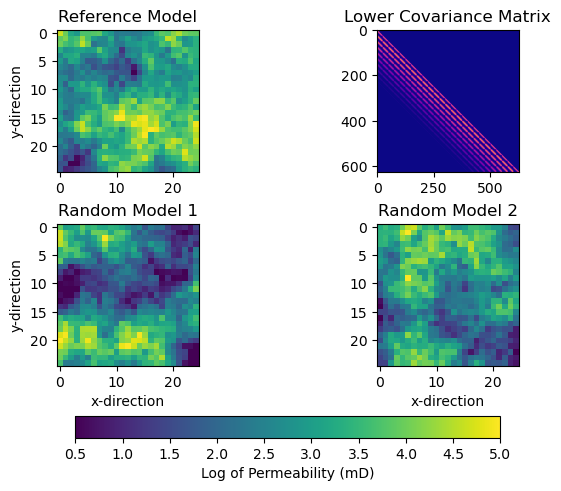

In [4]:
# QC covariance, reference model, and first two random models
fig, axs = plt.subplots(2, 2, constrained_layout=True)
axs[0, 0].set_title('Reference Model')
im = axs[0, 0].imshow(MReference.T, vmin=perm_min, vmax=perm_max)
axs[0, 1].set_title('Lower Covariance Matrix')
im2 = axs[0, 1].imshow(RP.cov, cmap='plasma')
axs[1, 0].set_title('Random Model 1')
axs[1, 0].imshow(MGridPrior[0, ...].T, vmin=perm_min, vmax=perm_max)
axs[1, 1].set_title('Random Model 2')
axs[1, 1].imshow(MGridPrior[1, ...].T, vmin=perm_min, vmax=perm_max)
fig.colorbar(im, ax=axs[1, :], orientation='horizontal', label='Log of Permeability (mD)')
for ax in axs[1, :]:
    ax.set_xlabel('x-direction')
for ax in axs[:, 0]:
    ax.set_ylabel('y-direction')

## Run the prior models and the reference case

In [5]:
#Instantiate reservoir simulator
RS = rs.Simulator(nx, ny, wells=wells)

# Simulate the 100 fields and the reference field
DPrior = RS(np.exp(MGridPrior), dt=dt, data=(ox, oy))
dObs = RS(np.exp(MReference), dt=dt, data=(ox, oy))

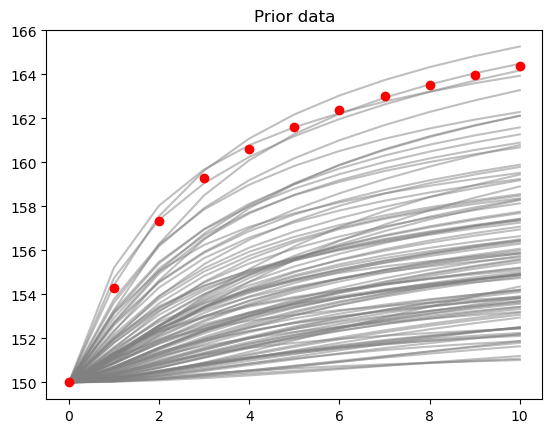

In [6]:
# QC data and priors
fig, ax = plt.subplots(1, 1)
ax.set_title('Prior data')
ax.plot(DPrior.T, color='gray', alpha=0.5)
ax.plot(dObs, 'ro', label='reference case');

### Create the perturbed observations for ESMDA

We will create a set of perturbed observations that will serve as our observations for ESMDA. These observations are generated by adding a random noise to the reference case observations.

In [7]:
dstd = 2 * np.ones_like(dObs)
# Associated standard deviation: ones (for this scenario)
dstd = np.ones(dObs.size)*0.1
Ce = np.diag(dstd**2)

### ESMDA

Here we implement the ESMDA algorithm. This involves multiple assimilation steps, where we update our model parameters using observed data. The key components include:

Perturbing the observed data.

Calculating the Kalman gain.

Updating the model parameters.

Each assimilation step refines our model parameters, aiming to reduce the discrepancy between the model and the observed data.

In [8]:
D_it = np.zeros((na, ne, nt))
D_it[0, :] = DPrior

MGrid = MGridPrior
for l, alpha in enumerate(alphas):
    print(f"Assimilation step {l+1}")

    # Perturb the observation for each ensemble member
    Dobs = np.transpose(dObs + alphas[0]*dstd*rs.rng.normal(size=(ne, nt)))

    # Get data
    if l > 0:   
        D_it[l, :] = RS(np.exp(MGrid), dt=dt, data=(ox, oy))

    # Mean of the ensemble parameters
    deltaM = MGrid - MGrid.mean(axis=0)

    # Mean of the ensemble data
    deltaD = (D_it[l, :].T - D_it[l, :].mean(axis=1)).T

    # Kalman gain
    # np.linalg.inv does not work well for real-live problems:
    # use subspace inversions  with woodbury matrix identity
    K = (deltaM.T@deltaD)@np.linalg.inv((deltaD.T@deltaD + alphas[0]*(ne-1)*Ce))

    # Update the ensemble parameters
    MGrid = np.clip(MGrid + (K@(Dobs-D_it[l, :].T)).T, perm_min, perm_max)
    
MGridPost = MGrid

Assimilation step 1
Assimilation step 2
Assimilation step 3
Assimilation step 4


### Posterior Analysis
After running ESMDA, it's crucial to analyze the posterior ensemble of models. Here, we visualize the first three realizations from both the prior and posterior ensembles to see how the models have been updated.

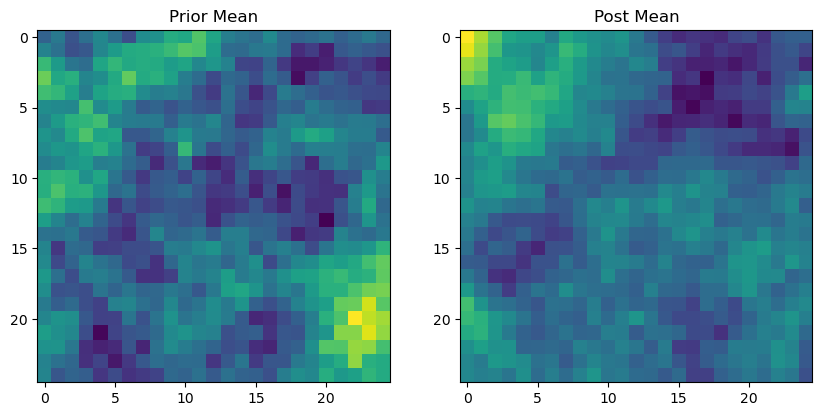

In [9]:
# Plot posterior
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Prior Mean')
ax[0].imshow(MGridPrior.mean(axis=0).T)
ax[1].set_title('Post Mean');
ax[1].imshow(MGridPost.mean(axis=0).T);

In [10]:
# Run the posterior
DPost = RS(np.exp(MGridPost), dt=dt, data=(ox, oy))

Observing the monitored pressure at cell (1,1) for all realizations and the reference case, we can see that the ensemble of models after the assimilation steps (in blue) is closer to the reference case (in red) than the prior ensemble (in gray). This indicates that the ESMDA method is effectively updating the models to better represent the observed data.

In [11]:
# Plot the monitored pressure at cell (ox, oy) for all 11 fields
noisy_obs = dObs + rs.rng.normal(0, dstd, size=len(dObs))

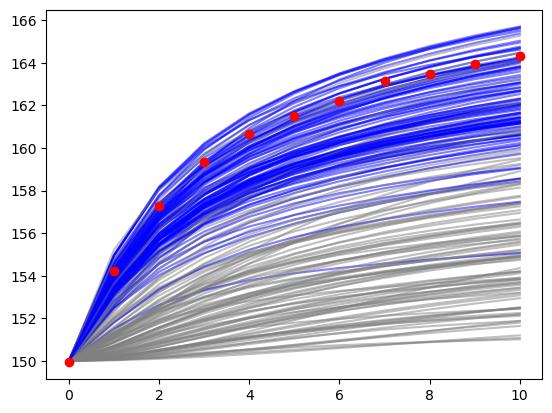

In [12]:
# Plot data
for i in range(ne):
    plt.plot(DPrior[i, :], color='gray', alpha=0.5)
    plt.plot(DPost[i, :], color='blue', alpha=0.5)
plt.plot(noisy_obs, label='reference case' , marker='o', linestyle='', color = 'red');

In [13]:
import scooby
scooby.Report()

--------------------------------------------------------------------------------
  Date: Fri Apr 19 13:55:53 2024 CEST

                OS : Linux
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06)
  [GCC 11.3.0]

             numpy : 1.24.4
             scipy : 1.11.1
           IPython : 8.12.0
        matplotlib : 3.7.2
            scooby : 0.7.2

  Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804
  for Intel(R) 64 architecture applications
--------------------------------------------------------------------------------